Задача uplift моделирования.

In [1]:
# обработка

import pandas as pd
import numpy as np
import datetime

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# моделирование
import lightgbm as lgbm

In [2]:
# загружаем данные, даты принимаем как отдельный тип данных

df_clients = pd.read_csv('D:\\Work\\data\\retail\\clients.csv', index_col='client_id', parse_dates=['first_issue_date','first_redeem_date'])
df_train = pd.read_csv('D:\\Work\\data\\retail\\uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('D:\\Work\\data\\retail\\uplift_test.csv', index_col='client_id')
df_products = pd.read_csv('D:\\Work\\data\\retail\\products.csv', index_col='product_id')
df_purchases = pd.read_csv('D:\\Work\\data\\retail\\purchases.csv', parse_dates=['transaction_datetime'])

In [3]:
# выделим дату

df_purchases['date'] = df_purchases['transaction_datetime'].dt.date

In [4]:
day_counts = df_purchases.groupby('date').count()

In [5]:
day_counts

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
date,,,,,,,,,,,,,
2018-11-21,190,190,190,190,190,190,190,190,190,190,190,190,0
2018-11-22,338469,338469,338469,338469,338469,338469,338469,338469,338469,338469,338469,338469,19217
2018-11-23,379366,379366,379366,379366,379366,379366,379366,379366,379366,379366,379366,379366,20910
2018-11-24,356983,356983,356983,356983,356983,356983,356983,356983,356983,356983,356983,356983,19364
2018-11-25,320488,320488,320488,320488,320488,320488,320488,320488,320488,320488,320488,320488,16185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-14,491228,491228,491228,491228,491228,491228,491228,491228,491228,491228,491228,491228,26103
2019-03-15,552207,552207,552207,552207,552207,552207,552207,552207,552207,552207,552207,552207,32521
2019-03-16,460425,460425,460425,460425,460425,460425,460425,460425,460425,460425,460425,460425,32479


Данные по дням распределены достаточно равномерно кроме первого дня.

In [6]:
day_counts.describe()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,388021.762712,25791.152542
std,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,82111.531981,8566.187221
min,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,0.000000
25%,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,340538.250000,21445.750000
50%,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,379358.500000,24476.500000
75%,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,436168.000000,28748.750000
max,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,621704.000000,82924.000000


Многие поля приджойнены из таблицы транзаций: purchase_sum - сумма транзакции, если просуммировать trn_sum_from_iss по транзации то в большинстве случаев получится purchase_sum, кроме транзакций где было расходование бонусных баллов.

In [7]:
df_purchases.head(20)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,date
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,2018-12-01
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,2018-12-01
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,2018-12-01
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,2018-12-01
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,2018-12-01
5,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,21db5dbe53,1.0,34.0,NaN,2018-12-01
6,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,1e208d0b4c,1.0,24.0,NaN,2018-12-01
7,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,15ccaa8685,1.0,51.0,NaN,2018-12-01
8,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,45389bb5b0,1.0,23.0,NaN,2018-12-01
9,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,cb4c804130,1.0,60.0,NaN,2018-12-01


В качестве переменных возьмем:  
- количество покупок всего и за последние 30 дней,  
- их суммы, количество накопленных и потраченных баллов,  
- количество уникальных магазинов сети в которых производились покупки.

In [8]:
last_cols = ['regular_points_received', 'express_points_received','regular_points_spent', 'express_points_spent', 'purchase_sum','store_id']
all_hist = df_purchases.groupby(['client_id','transaction_id'])[last_cols].last()
last_month = df_purchases[df_purchases['transaction_datetime'] > '2019-02-18'].groupby(['client_id','transaction_id'])[last_cols].last()

In [9]:
# посмотрим количество уникальных значений каждой переменной

features =  pd.concat([all_hist.groupby('client_id')['purchase_sum'].count(),
                       last_month.groupby('client_id')['purchase_sum'].count(),
                       all_hist.groupby('client_id').sum(),
                       all_hist.groupby('client_id')[['store_id']].nunique(),
                       last_month.groupby('client_id').sum(),
                       last_month.groupby('client_id')[['store_id']].nunique(),
                      ],axis = 1)
features.columns = ['total_trans_count','last_month_trans_count']+list(c+"_sum_all" for c in last_cols)+list(c+"_sum_last_month" for c in last_cols)

In [10]:
features

,total_trans_count,last_month_trans_count,regular_points_received_sum_all,express_points_received_sum_all,regular_points_spent_sum_all,express_points_spent_sum_all,purchase_sum_sum_all,store_id_sum_all,regular_points_received_sum_last_month,express_points_received_sum_last_month,regular_points_spent_sum_last_month,express_points_spent_sum_last_month,purchase_sum_sum_last_month,store_id_sum_last_month
client_id,,,,,,,,,,,,,,
000012768d,4,2,25.7,0.0,0.0,0.0,2803.00,3,10.0,0.0,0.0,0.0,1222.00,1
000036f903,32,8,54.9,60.0,0.0,0.0,9805.00,5,13.7,0.0,0.0,0.0,2784.00,4
000048b7a6,8,1,26.5,0.0,0.0,0.0,3772.00,2,1.2,0.0,0.0,0.0,342.00,1
000073194a,17,6,74.9,0.0,-96.0,0.0,9601.40,1,25.0,0.0,0.0,0.0,3393.30,1
00007c7133,11,1,56.6,0.0,-240.0,0.0,6719.84,2,1.9,0.0,0.0,0.0,380.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffece623e,24,5,38.4,0.0,-68.0,0.0,6530.01,3,4.3,0.0,0.0,0.0,917.82,1
ffff3dfff8,17,5,117.9,0.0,-182.0,0.0,7264.84,1,16.2,0.0,0.0,0.0,2149.34,1
ffffaab9da,7,2,34.0,0.0,-6.0,0.0,3791.00,1,9.8,0.0,0.0,0.0,1116.00,1


Добавим переменные по дате/времени покупок (и разницу) и пол:

In [11]:
merged_train = pd.concat([df_train,df_clients,features],axis = 1,sort = True)
merged_train = merged_train[~merged_train['target'].isnull()].copy()
merged_train['first_issue_date_weekday'] = merged_train['first_issue_date'].dt.weekday
merged_train['first_redeem_date_weekday'] = merged_train['first_redeem_date'].dt.weekday
merged_train['first_issue_date_hour'] = merged_train['first_issue_date'].dt.hour
merged_train['first_redeem_date_hour'] = merged_train['first_redeem_date'].dt.hour
merged_train['first_issue_date'] = merged_train['first_issue_date'].astype(np.int64)/10**9
merged_train['first_redeem_date'] = merged_train['first_redeem_date'].values.astype(np.float64)/10**9
merged_train['diff'] = merged_train['first_redeem_date']-merged_train['first_issue_date']
merged_train['gender'] = list(ord(v[0]) for v in merged_train['gender'].values)

Сделаем датасеты под 2 модели:

In [12]:
# учебная

treatment = merged_train[merged_train['treatment_flg'] == 1].drop('treatment_flg',axis = 1)
treatment_x = treatment.drop('target',axis = 1)
treatment_y = treatment['target']

# контрольная

control = merged_train[merged_train['treatment_flg'] == 0].drop('treatment_flg',axis = 1)
control_x = control.drop('target',axis = 1)
control_y = control['target']

In [13]:
treatment_x.head()

,first_issue_date,first_redeem_date,age,gender,total_trans_count,last_month_trans_count,regular_points_received_sum_all,express_points_received_sum_all,regular_points_spent_sum_all,express_points_spent_sum_all,...,express_points_received_sum_last_month,regular_points_spent_sum_last_month,express_points_spent_sum_last_month,purchase_sum_sum_last_month,store_id_sum_last_month,first_issue_date_weekday,first_redeem_date_weekday,first_issue_date_hour,first_redeem_date_hour,diff
000036f903,1.491832e+09,1.492951e+09,72,70,32,8,54.9,60.0,0.0,0.0,...,0.0,0.0,0.0,2784.00,4,0,6.0,13,12.0,1118613.0
00010925a5,1.532449e+09,1.536942e+09,83,85,18,8,31.8,0.0,-17.0,0.0,...,0.0,0.0,0.0,2858.00,2,1,4.0,16,16.0,4492280.0
0001f552b0,1.498850e+09,1.535461e+09,33,70,15,7,78.9,0.0,0.0,0.0,...,0.0,0.0,0.0,2211.37,2,4,1.0,19,12.0,36610747.0
00020e7b18,1.511783e+09,1.515607e+09,73,85,18,5,286.1,0.0,-592.0,-30.0,...,0.0,-76.0,-10.0,6096.27,1,0,2.0,11,17.0,3823700.0
00022fd34f,1.513359e+09,1.525809e+09,65,85,33,10,67.0,0.0,-48.0,0.0,...,0.0,0.0,0.0,2825.79,1,4,1.0,17,19.0,12449413.0


Будем обучать lightgbm и вначале сделаем небольшой cv на количество деревьев:

In [14]:
# параметры модели

params = {'learning_rate':0.03,'max_depth':4,'num_leaves':20,
             'min_data_in_leaf':3, 'application':'binary',
             'subsample':0.8, 'colsample_bytree': 0.8,
             'reg_alpha':0.01,'data_random_seed':42,'metric':'binary_logloss',
             'max_bin':416,'bagging_freq':3,'reg_lambda':0.01,'num_leaves':20             
    }
matrix_lgbm = lgbm.Dataset(treatment_x, label=treatment_y, silent=True)
cv_result_lgbm = lgbm.cv(params, matrix_lgbm, num_boost_round=5000, nfold=5, stratified=True, 
                              early_stopping_rounds=50, seed=13)

[LightGBM] [Info] Number of positive: 50911, number of negative: 29073
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4159
[LightGBM] [Info] Number of data points in the train set: 79984, number of used features: 23
[LightGBM] [Info] Number of positive: 50911, number of negative: 29074
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4159
[LightGBM] [Info] Number of data points in the train set: 79985, number of used features: 23
[LightGBM] [Info] Number of positive: 50911, number of negative: 29074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead o

Обучим основные модели

In [15]:
pd.DataFrame.from_dict(cv_result_lgbm).mean()

binary_logloss-mean    0.537884
binary_logloss-stdv    0.001939
dtype: float64

In [16]:
# учебная

treatment_model_lgbm = lgbm.LGBMClassifier(n_estimators = len(cv_result_lgbm['binary_logloss-mean']), **params)
treatment_model_lgbm.fit(treatment_x,treatment_y)

# контрольная

control_model_lgbm = lgbm.LGBMClassifier(n_estimators = len(cv_result_lgbm['binary_logloss-mean']), **params)
control_model_lgbm.fit(control_x,control_y)

LGBMClassifier(application='binary', bagging_freq=3, colsample_bytree=0.8,
               data_random_seed=42, learning_rate=0.03, max_bin=416,
               max_depth=4, metric='binary_logloss', min_data_in_leaf=3,
               n_estimators=497, num_leaves=20, reg_alpha=0.01, reg_lambda=0.01,
               subsample=0.8)

Посмотрим "вес" переменных:

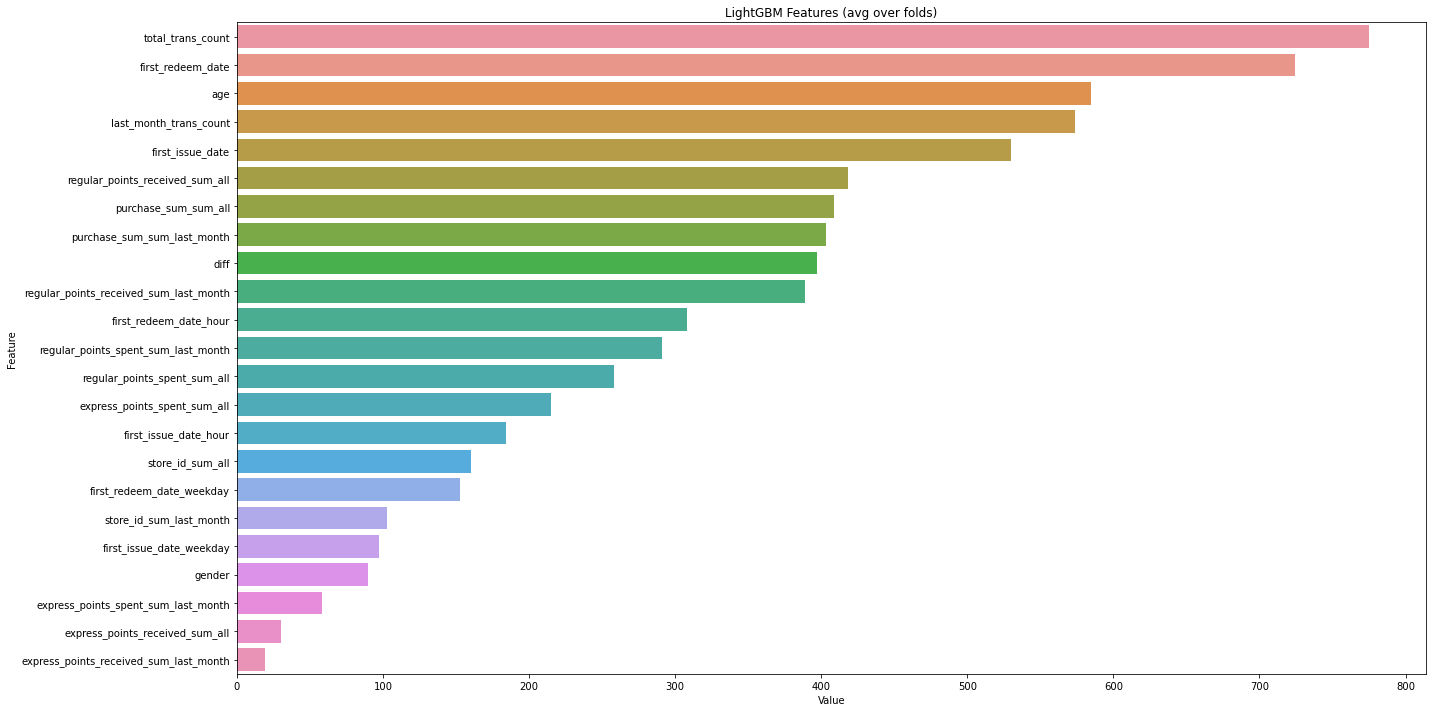

In [17]:
feature_imp = pd.DataFrame(sorted(zip(treatment_model_lgbm.feature_importances_, treatment_x.columns)), columns=['Value', 'Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

Ожидаемо количество транзакций сильнее всего влияет, значит скорее всего на людей которые часто покупают СМС окажет большее влияение.

Сформируем тестовый dataset и смоделируем:

In [18]:
# проставим 1 для целевой в отдельный столбец

df_test['target'] = 1
merged_test = pd.concat([df_test, df_clients, features], axis = 1, sort = True)
merged_test = merged_test[~merged_test['target'].isnull()].copy()

In [19]:
merged_test['first_issue_date_weekday'] = merged_test['first_issue_date'].dt.weekday
merged_test['first_redeem_date_weekday'] = merged_test['first_redeem_date'].dt.weekday
merged_test['first_issue_date_hour'] = merged_test['first_issue_date'].dt.hour
merged_test['first_redeem_date_hour'] = merged_test['first_redeem_date'].dt.hour
merged_test['first_issue_date'] = merged_test['first_issue_date'].astype(np.int64)/10**9
merged_test['first_redeem_date'] = merged_test['first_redeem_date'].values.astype(np.int64)/10**9
merged_test['diff'] = merged_test['first_redeem_date']-merged_test['first_issue_date']
merged_test['gender'] = list(ord(v[0]) for v in merged_test['gender'].values)

In [20]:
# уберем столбец с разметкой из тестового набора

test_x = merged_test.drop('target',axis = 1)

In [21]:
# предскажем значения

preds_pos = treatment_model_lgbm.predict_proba(test_x)[:, 1]
preds_neg = control_model_lgbm.predict_proba(test_x)[:, 1]

In [22]:
merged_train.head()

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,total_trans_count,last_month_trans_count,regular_points_received_sum_all,express_points_received_sum_all,...,express_points_received_sum_last_month,regular_points_spent_sum_last_month,express_points_spent_sum_last_month,purchase_sum_sum_last_month,store_id_sum_last_month,first_issue_date_weekday,first_redeem_date_weekday,first_issue_date_hour,first_redeem_date_hour,diff
000012768d,0.0,1.0,1.501948e+09,1.515094e+09,45,85,4,2,25.7,0.0,...,0.0,0.0,0.0,1222.00,1,5,3.0,15,19.0,13146559.0
000036f903,1.0,1.0,1.491832e+09,1.492951e+09,72,70,32,8,54.9,60.0,...,0.0,0.0,0.0,2784.00,4,0,6.0,13,12.0,1118613.0
00010925a5,1.0,1.0,1.532449e+09,1.536942e+09,83,85,18,8,31.8,0.0,...,0.0,0.0,0.0,2858.00,2,1,4.0,16,16.0,4492280.0
0001f552b0,1.0,1.0,1.498850e+09,1.535461e+09,33,70,15,7,78.9,0.0,...,0.0,0.0,0.0,2211.37,2,4,1.0,19,12.0,36610747.0
00020e7b18,1.0,1.0,1.511783e+09,1.515607e+09,73,85,18,5,286.1,0.0,...,0.0,-76.0,-10.0,6096.27,1,0,2.0,11,17.0,3823700.0


Сохраним результат:

In [23]:
df_submission = pd.DataFrame({'client_id':test_x.index.values,'uplift': preds_pos-preds_neg})
df_submission.to_csv('D:\\Work\\data\\retail\\submission.csv',index = False)